In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import cv2
import random

ModuleNotFoundError: No module named 'tensorflow'

In [66]:
# Base directory containing train, val, test folders
base_dir = 'pls' 

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_labels_csv = os.path.join(train_dir, 'labels.csv')
val_labels_csv = os.path.join(val_dir, 'labels.csv')
test_labels_csv = os.path.join(test_dir, 'labels.csv')

# --- Model & Training Parameters ---
IMG_WIDTH = 32
IMG_HEIGHT = 32
IMG_CHANNELS = 1 
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
BATCH_SIZE = 64 
EPOCHS = 20     

In [ ]:
try:
    train_df = pd.read_csv(train_labels_csv)
    val_df = pd.read_csv(val_labels_csv)
    test_df = pd.read_csv(test_labels_csv)

    print("Train DataFrame Head:")
    print(train_df.head())
    print(f"\nTotal Train Samples: {len(train_df)}")
    print(f"Total Validation Samples: {len(val_df)}")
    print(f"Total Test Samples: {len(test_df)}")

except FileNotFoundError as e:
    print(f"Error loading CSV: {e}")
    print("Please ensure the root directory and the 'labels.csv' files exist in the correct locations.")
    # Stop execution if files aren't found
    raise SystemExit("CSV file not found.")

print("\nMissing values in train_df:", train_df.isnull().sum().sum())
print("Missing values in val_df:", val_df.isnull().sum().sum())
print("Missing values in test_df:", test_df.isnull().sum().sum())

# Ensure column names are correct (adjust if needed)
required_columns = ['filename', 'words']
if not all(col in train_df.columns for col in required_columns):
     raise ValueError(f"Train CSV must contain columns: {required_columns}")
if not all(col in val_df.columns for col in required_columns):
     raise ValueError(f"Validation CSV must contain columns: {required_columns}")
if not all(col in test_df.columns for col in required_columns):
     raise ValueError(f"Test CSV must contain columns: {required_columns}")

label_column_name = 'words'

print(f"\nUsing label column: '{label_column_name}'")

Train DataFrame Head:
                     filename words
0  character_10_yna/13839.png     ञ
1  character_10_yna/79348.png     ञ
2  character_10_yna/23260.png     ञ
3  character_10_yna/57417.png     ञ
4  character_10_yna/19463.png     ञ

Total Train Samples: 73600
Total Validation Samples: 9200
Total Test Samples: 9200

Missing values in train_df: 0
Missing values in val_df: 0
Missing values in test_df: 0

Using label column: 'words'


In [68]:
# Finding all the unique characters across train, val, test sets
all_labels = pd.concat([train_df[label_column_name], 
                        val_df[label_column_name], 
                        test_df[label_column_name]], ignore_index=True)
unique_labels = sorted(all_labels.unique())
num_classes = len(unique_labels)

print(f"\nTotal unique classes (Devanagari characters): {num_classes}")

label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_to_label = {i: label for label, i in label_to_int.items()}
print(int_to_label)


Total unique classes (Devanagari characters): 46
{0: 'क', 1: 'क्ष', 2: 'ख', 3: 'ग', 4: 'घ', 5: 'ङ', 6: 'च', 7: 'छ', 8: 'ज', 9: 'ज्ञ', 10: 'झ', 11: 'ञ', 12: 'ट', 13: 'ठ', 14: 'ड', 15: 'ढ', 16: 'ण', 17: 'त', 18: 'त्र', 19: 'थ', 20: 'द', 21: 'ध', 22: 'न', 23: 'प', 24: 'फ', 25: 'ब', 26: 'भ', 27: 'म', 28: 'य', 29: 'र', 30: 'ल', 31: 'व', 32: 'श', 33: 'ष', 34: 'स', 35: 'ह', 36: '०', 37: '१', 38: '२', 39: '३', 40: '४', 41: '५', 42: '६', 43: '७', 44: '८', 45: '९'}


In [69]:
print(unique_labels)

['क', 'क्ष', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'ज्ञ', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'त्र', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९']


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=INPUT_SHAPE),

        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),          

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dropout(0.5),                                    # Dropout for regularization
        layers.Dense(256, activation="relu"),                   # Add a dense layer
        layers.Dropout(0.3),                                    # Optional dropout
        layers.Dense(num_classes, activation="softmax"),        # Output layer
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 46)             │        11,822 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 620,718 (2.37 MB)

 Trainable params: 620,718 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,      # degrees
    width_shift_range=0.1,  # fraction of total width
    height_shift_range=0.1, # fraction of total height
    shear_range=0.1,        # shear intensity (angle in counter-clockwise direction)
    zoom_range=0.1,         # random zoom range [1-zoom_range, 1+zoom_range]
    fill_mode='nearest'     # strategy used for filling points outside the input boundaries
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# --- Create Generators ---
print("\nCreating Training Generator...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,  # Directory where images referenced in df are located
    x_col='filename',     # Column in df that contains the filenames
    y_col=label_column_name,       # Column in df that has the target labels (characters)
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale' if IMG_CHANNELS == 1 else 'rgb', # 'grayscale' or 'rgb'
    classes=unique_labels, # Explicitly provide the class labels in sorted order
    class_mode='categorical', # Returns 2D one-hot encoded labels
    batch_size=BATCH_SIZE,
    shuffle=True,       
    seed=42               # For reproducibility
)

print("\nCreating Validation Generator...")
validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=val_dir,
    x_col='filename',
    y_col=label_column_name,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale' if IMG_CHANNELS == 1 else 'rgb',
    classes=unique_labels,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("\nCreating Test Generator...")
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=label_column_name,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale' if IMG_CHANNELS == 1 else 'rgb',
    classes=unique_labels,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

try:
    x_batch, y_batch = next(train_generator)
    print(f"\nSample batch shape: images={x_batch.shape}, labels={y_batch.shape}")
    # Check image range
    print(f"Image data range: min={np.min(x_batch)}, max={np.max(x_batch)}")
except Exception as e:
    print(f"\nError fetching batch from train_generator: {e}")
    print("Please check image paths in 'pls/train/labels.csv' and ensure images exist and are readable.")
    print("Example path expected by generator:", os.path.join(train_dir, train_df['filename'].iloc[0]))
    raise SystemExit("Error creating data generator.")


Creating Training Generator...
Found 73600 validated image filenames belonging to 46 classes.

Creating Validation Generator...
Found 9200 validated image filenames belonging to 46 classes.

Creating Test Generator...
Found 9200 validated image filenames belonging to 46 classes.

Sample batch shape: images=(64, 32, 32, 1), labels=(64, 46)
Image data range: min=0.0, max=1.0


In [72]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss_function = "categorical_crossentropy"

model.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])

In [ ]:
# Optional Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',   # Monitor validation accuracy
    patience=5,               # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

# Reduce learning rate if validation loss plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=3,
    min_lr=0.00001,
    verbose=1
)

print("\nStarting Training...")

# Calculate steps per epoch
steps_per_epoch = len(train_generator) 
validation_steps = len(validation_generator)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

print("\nTraining Finished.")

In [ ]:
model.save('first.keras')

In [22]:
model = tf.keras.models.load_model('first.keras')

In [ ]:
print("\nEvaluating on Test Set...")

test_steps = len(test_generator)

loss, accuracy = model.evaluate(
    test_generator,
    steps=test_steps, # Ensure all test samples are evaluated
    verbose=1
)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


Evaluating on Test Set...
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9857 - loss: 0.0490

Test Loss: 0.0420
Test Accuracy: 0.9879 (98.79%)


Below is the code if you want to check for any single marathi character 

In [ ]:


def preprocess_image_enhanced(image_path):
    # Load in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize to 32x32
    img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)

    # Invert colors: white background -> black, black text -> white
    img = cv2.bitwise_not(img)

    # Normalize to [0, 1]
    img = img.astype('float32') / 255.0

    # Expand dimensions: (1, 32, 32, 1)
    img = np.expand_dims(img, axis=(0, -1))

    return img


In [63]:

# Preprocess the image
processed_img = preprocess_image_enhanced("pls.jpg")

# Save the preprocessed image
cv2.imwrite("processed.jpg", (processed_img[0, :, :, 0] * 255).astype(np.uint8))  # Convert back to [0, 255]


True

In [ ]:

# Example: model = keras.models.load_model('path_to_your_model.h5')

# Make a prediction on the processed image
pred_prob = model.predict(processed_img)

# Get the predicted class (index)
pred_index = np.argmax(pred_prob)

# Map the predicted index back to the class label
predicted_label = int_to_label[pred_index]  # Ensure you have the int_to_label dictionary

print(f"Predicted Label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Label: ढ


Now we will recognize the handwritten sentence using our ocr model

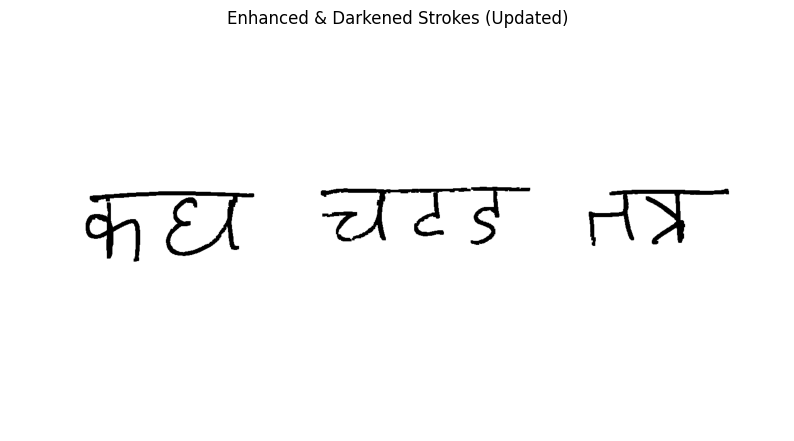

In [ ]:
def enhance_and_darken_strokes_updated(image_path, alpha=2.2, beta=25, kernel_size=(5, 5)):
    """
    - image_path: path to the input image.
    - alpha: contrast control.
    - beta: brightness control.
    - kernel_size: kernel size for dilation (stroke thickening).
    """
    # Read image
    img = cv2.imread(image_path)

    # Enhance brightness and contrast
    enhanced = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    #  Convert to grayscale
    gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)

    # Threshold (binary inverse: white bg, black text)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Dilate to darken/thicken strokes
    kernel = np.ones(kernel_size, np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=1)

    # convert back to BGR for saving as color image (or save binary)
    result = cv2.bitwise_not(dilated) 

    return result

# Paths
input_path = "word7.jpg"
output_path = "processed.jpg"

# Process image with updated function (slightly larger default kernel)
processed_img = enhance_and_darken_strokes_updated(input_path)

# Save result
cv2.imwrite(output_path, processed_img)

# Show result
plt.figure(figsize=(10, 6))
plt.imshow(processed_img, cmap='gray')
plt.title("Enhanced & Darkened Strokes (Updated)")
plt.axis("off")
plt.show()

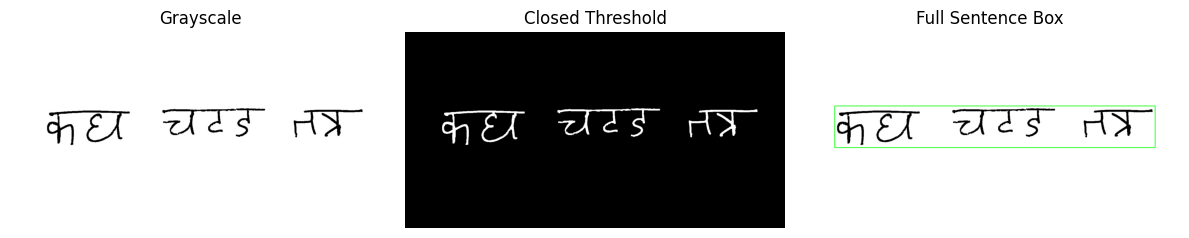

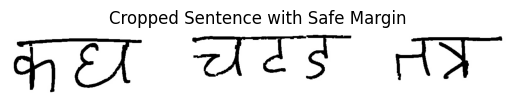

In [ ]:
def crop_sentence_safe_margin(image_path, padding=10, show_steps=False):
    # Read and preprocess
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Binary inverse + Otsu thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morph closing to remove gaps
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]  # Filter noise

    if not contours:
        print("No valid contours found.")
        return img

    # Find bounding box that covers all contours (the full sentence)
    all_points = np.vstack(contours)
    x, y, w, h = cv2.boundingRect(all_points)

    # Add safe margins
    x1 = max(x - padding, 0)
    y1 = max(y - padding, 0)
    x2 = min(x + w + padding, img.shape[1])
    y2 = min(y + h + padding, img.shape[0])

    cropped = img[y1:y2, x1:x2]

    # Optional visualization
    if show_steps:
        boxed = img.copy()
        cv2.rectangle(boxed, (x1, y1), (x2, y2), (0, 255, 0), 2)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(gray, cmap='gray')
        plt.title("Grayscale")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(closed, cmap='gray')
        plt.title("Closed Threshold")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(boxed, cv2.COLOR_BGR2RGB))
        plt.title("Full Sentence Box")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    return cropped

# Example usage
image_path = "processed.jpg"
cropped_img = crop_sentence_safe_margin(image_path, padding=10, show_steps=True)

# Save and show result
cv2.imwrite("processed.jpg", cropped_img)
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.title("Cropped Sentence with Safe Margin")
plt.axis("off")
plt.show()

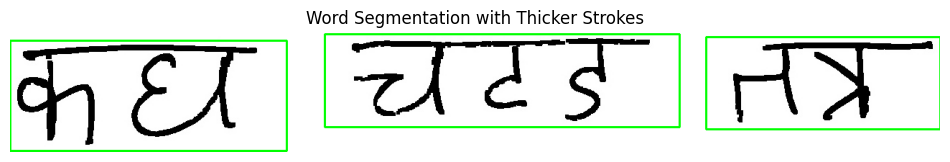

✅ Total words extracted (strong dilation): 3


In [ ]:
def segment_words_thicker_strokes(image, output_dir=None, show_steps=False):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Apply slight blur to suppress noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Adaptive thresholding for variable lighting and thin strokes
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 15
    )

    # Dilation to connect broken lines and thin strokes more aggressively
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 8))  # Wider + taller kernel
    dilated = cv2.dilate(thresh, kernel, iterations=2)  # More iterations to thicken more

    # Find contours for word-level blobs
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    raw_boxes = [cv2.boundingRect(cnt) for cnt in contours if cv2.contourArea(cnt) > 100]

# Remove nested boxes
    def is_inside(inner, outer):
        xi, yi, wi, hi = inner
        xo, yo, wo, ho = outer
        return xi >= xo and yi >= yo and xi + wi <= xo + wo and yi + hi <= yo + ho

    filtered_boxes = []
    for i, box in enumerate(raw_boxes):
        if not any(i != j and is_inside(box, other) for j, other in enumerate(raw_boxes)):
            filtered_boxes.append(box)

    boxes = sorted(filtered_boxes, key=lambda b: b[0])


    word_images = []
    for i, (x, y, w, h) in enumerate(boxes):
        word_crop = image[y:y+h, x:x+w]
        word_images.append(word_crop)
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            cv2.imwrite(os.path.join(output_dir, f"word_{i+1}.jpg"), word_crop)

    if show_steps:
        visual = image.copy()
        for (x, y, w, h) in boxes:
            cv2.rectangle(visual, (x, y), (x+w, y+h), (0, 255, 0), 2)
        plt.figure(figsize=(12, 5))
        plt.imshow(cv2.cvtColor(visual, cv2.COLOR_BGR2RGB))
        plt.title("Word Segmentation with Thicker Strokes")
        plt.axis("off")
        plt.show()

    return word_images

# Example usage
img_path = "processed.jpg"
img = cv2.imread(img_path)

word_imgs = segment_words_thicker_strokes(img, output_dir=None, show_steps=True)
print(f"✅ Total words extracted (strong dilation): {len(word_imgs)}")

In [ ]:
top_height_to_remove = 0

def segment_characters_from_word(word_img, show_steps=False):
    # Preprocess the word image
    gray = cv2.cvtColor(word_img, cv2.COLOR_BGR2GRAY) if len(word_img.shape) == 3 else word_img
    blur = cv2.GaussianBlur(gray, (3, 3), 1)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Optionally remove top 1/4th rows to avoid shirorekha interference
    h = thresh.shape[0]
    no_shirorekha = thresh[int(h * 0.25):, :]
    top_height_to_remove = int(h * 0.25)

    # Find character contours
    contours, _ = cv2.findContours(no_shirorekha.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = [cv2.boundingRect(cnt) for cnt in contours if cv2.contourArea(cnt) > 50]
    boxes = sorted(boxes, key=lambda b: b[0])  # Sort left to right

    character_images = []
    for i, (x, y, w, h) in enumerate(boxes):
        # Adjust y back since we cropped top of the image (after removing shirorekha adjust it back)
        char_crop = word_img[y: y + h + int(thresh.shape[0] * 0.25), x:x + w]
        character_images.append(char_crop)

    if show_steps:
        visual = word_img.copy()
        for (x, y, w, h) in boxes:
            # y += int(thresh.shape[0] * 0.25)  # adjust for visualization
            cv2.rectangle(visual, (x, y), (x + w, y + h + int(thresh.shape[0] * 0.25)), (0, 255, 0), 1)
        plt.figure(figsize=(10, 4))
        plt.imshow(cv2.cvtColor(visual, cv2.COLOR_BGR2RGB))
        plt.title("Character Segmentation")
        plt.axis("off")
        plt.show()

    return character_images


🧩 Characters in word 1:


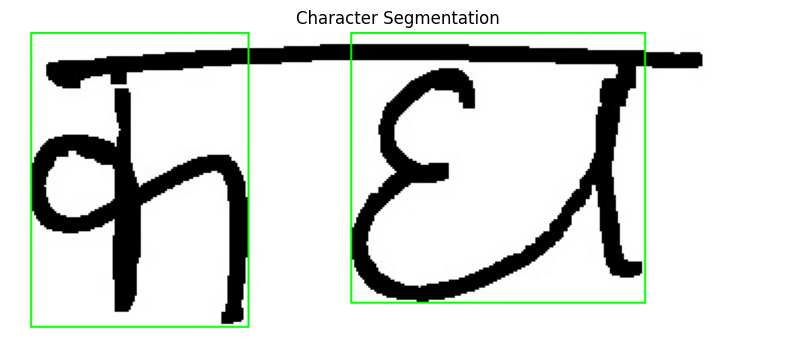


🧩 Characters in word 2:


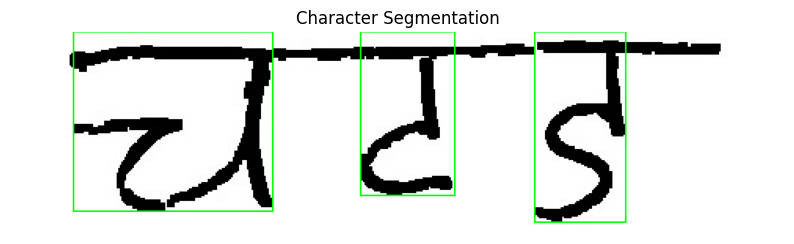


🧩 Characters in word 3:


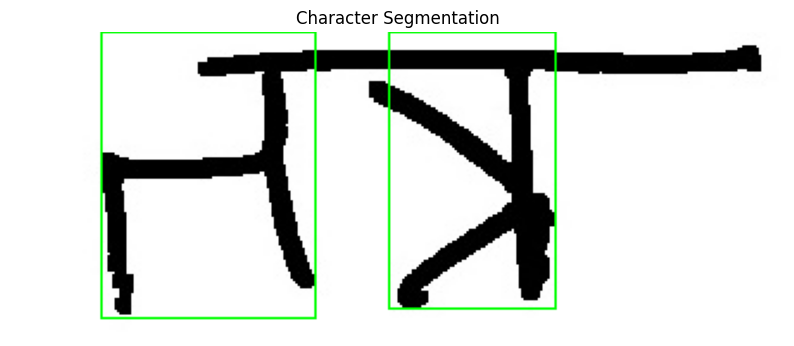

In [53]:
# word_imgs is a list of segmented word images
for idx, word_img in enumerate(word_imgs):
    print(f"\n🧩 Characters in word {idx+1}:")
    char_imgs = segment_characters_from_word(word_img, show_steps=True)

In [55]:
model = tf.keras.models.load_model('first.keras')

In [56]:
def preprocess_image_enhanced(image):
    # If it's a color image, convert to grayscale
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize to 32x32
    img = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)

    # Invert colors
    img = cv2.bitwise_not(img)

    # Normalize to [0, 1] file k liyye
    img = img.astype('float32') / 255.0

    # Expand dims: shape (1, 32, 32, 1) for model input
    img = np.expand_dims(img, axis=(0, -1))

    return img


कघ

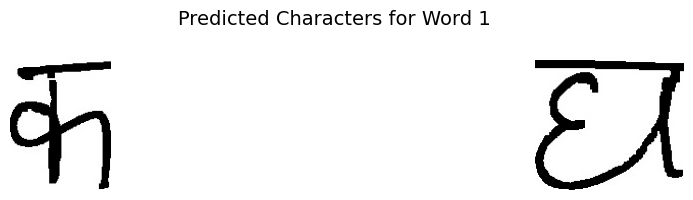

चटड

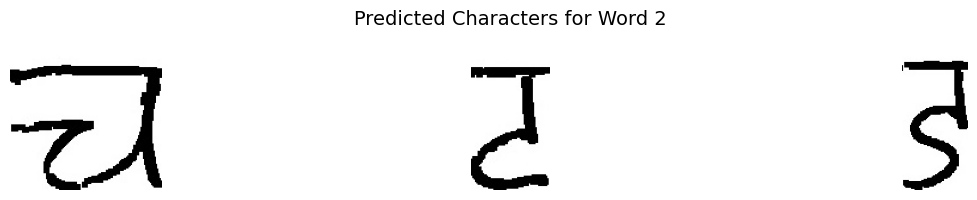

नत्र

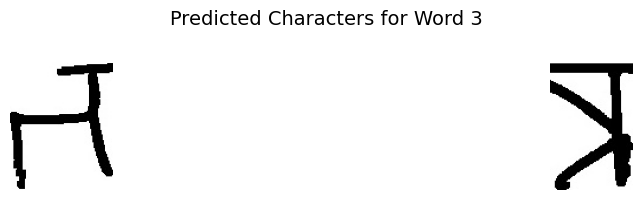

In [57]:
def display_and_predict_all_characters(word_images, int_to_label):
    for word_index, word_img in enumerate(word_images, 1):
        char_imgs = segment_characters_from_word(word_img, show_steps=False)
        plt.figure(figsize=(15, 2))

        for i, char_img in enumerate(char_imgs):
            # Preprocess
            processed_img = preprocess_image_enhanced(char_img)

            # Predict
            pred_prob = model.predict(processed_img, verbose=0)
            pred_index = np.argmax(pred_prob)
            predicted_label = int_to_label[pred_index]

            # Display
            plt.subplot(1, len(char_imgs), i + 1)
            if len(char_img.shape) == 3:
                plt.imshow(cv2.cvtColor(char_img, cv2.COLOR_BGR2RGB), cmap='gray')
            else:
                plt.imshow(char_img, cmap='gray')
            plt.axis('off')
            # plt.title(f"{predicted_label}")
            print(f"{predicted_label}",end="")

        plt.suptitle(f"Predicted Characters for Word {word_index}", fontsize=14)
        plt.tight_layout()
        plt.show()

# 🧪 Run it
display_and_predict_all_characters(word_imgs, int_to_label)